In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import multiprocessing as mp
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'legend.fontsize': 12})

def BS(x):
    '''
    Black scholes formula
    '''
    D1 =(np.log(x/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    D2 = D1 - sig*np.sqrt(T)
    c=x*norm.cdf(D1)-K*np.exp(-r*T)*norm.cdf(D2)
    return c

def _parallel_mc(iter=1000):
    pool = mp.Pool(4)

    future_res = [pool.apply_async(sample) for _ in range(iter)]
    res = [f.get() for f in future_res]

    return res

In [72]:
class Option:
    def __init__(self,X0=100,r=0.05,sig=0.2,K=100,T=1):
        self.X0=X0
        self.r=r
        self.sig=sig
        self.K=K
        self.T=T
        
    #Virtual functions to be overridden by specific sub-classes
    def payoff(self,N_loop,l): #Depends on option type
        raise NotImplementedError()
    def path(self,N_loop,l): #Depends on underlying SDE
        raise NotImplementedError()
        
    #~~~Common functions to all sub-classes~~~#
    ##Interfaces with mlmc algorithm
    def looper(self,Nl,l,M,Npl=10**4):
        num_rem=Nl #Initialise remaining samples for while loop
        suml=np.zeros(7)
        while (num_rem>0): #<---Parallelise this while loop
            N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
            num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and loop terminates
            Pf,Pc=self.payoff(N_loop,l,M)
            sumPf=np.sum(Pf)
            sumPf2=np.sum(Pf**2)
            if l==0:
                suml+=np.array([sumPf,sumPf2,sumPf,sumPf2,0,0,0])
            else:
                dP_l=Pf-Pc #Payoff difference
                sumPc=np.sum(Pc)
                sumPc2=np.sum(Pc**2)
                fg=np.sum(Pc*Pf)
                suml+=np.array([np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,fg])
                
        return suml 

    ##MLMC function
    def mlmc(self,eps,M=2,N0=10**3):
        '''
        Example usage:
        Euro=Euro_GBM()
        sums,N=Euro.mlmc(0.1)
        
        Runs MLMC method for given option (e.g. European) which returns an array of sums at each level: 
        suml=[d_Pl,d_Pl**2,Pl,Pl**2].
        __Inputs__
        option = option instance (with SDE params and coarseness factor M)
        eps = desired accuracy
        N0 = default number of samples to use when initialising new level
        M=coarseness factor

        __Outputs__
        sums = array of sums of payoff differences between coarse and fine paths at each level and
               sum of payoffs at fine level, each column is a level
        N = final number of samples at each level
        '''
        L=2

        V=np.zeros(L+1) #Initialise variance vector of each levels' variance
        N=N0*np.ones(L+1) #Initialise num. samples vector of each levels' num. samples
        dN=N0*np.ones(L+1) #Initialise additional samples for this iteration vector for each level
        sums=np.zeros((7,L+1)) #Initialise sums array, each column is a level
        sqrt_h=np.sqrt(M**(np.arange(L+1)))

        while (np.sum(dN)>0): #Loop until no additional samples asked for
            for l in range(L+1): 
                num=dN[l]
                if num>0: #If asked for additional samples...
                    sums[:,l]+=self.looper(int(num),l,M) #Call function which gives sums


            N+=dN #Increment samples taken counter for each level        
            V=np.maximum((sums[1,:]/N)-(sums[0,:]/N)**2,0) #Calculate variance based on updated samples
            sqrt_V=np.sqrt(V)
            Nl_new=np.ceil((2/eps**2)*np.sum(sqrt_V*sqrt_h)*sqrt_V/sqrt_h) #Estimate optimal number of samples at each level
            dN=np.maximum(0,Nl_new-N) #Number of additional samples
            if sum(dN > 0.01*N) == 0:
                if abs(sums[0,-1])/N[-1]>(M-1)*eps*np.sqrt(0.5):
                    L+=1
                    #Add extra entries for the new level and estimate sums with N0 samples 
                    V=np.concatenate((V,np.zeros(1)), axis=0)
                    N=np.concatenate((N,N0*np.ones(1)),axis=0)
                    dN=np.concatenate((dN,N0*np.ones(1)),axis=0)
                    sqrt_h=np.concatenate((sqrt_h,[np.sqrt(M**L)]),axis=0)
                    sums=np.concatenate((sums,np.zeros((7,1))),axis=1)
                    sums[:,L]+=self.looper(N0,L,M)

        return sums,N

class Euro_GBM(Option):
    def path(self,N_loop,l,M):
        r=self.r
        sig=self.sig
        T=self.T
        X0=self.X0
        Nsteps=M**l
        dt=T/Nsteps
        sqrt_dt=np.sqrt(dt)
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0
        return Xf,Xc
    
    def payoff(self,N_loop,l,M):
        r=self.r
        K=self.K
        T=self.T
        Xf,Xc=self.path(N_loop,l,M)
        #Calculate payoffs etc.
        Pf=np.maximum(0,Xf-K)
        Pf=np.exp(-r*T)*Pf
        if l==0:
            return Pf,Xc #Just ignore Pc=Xc
        else:
            Pc=np.maximum(0,Xc-K)
            Pc=np.exp(-r*T)*Pc #Payoff at coarse level
            return Pf,Pc
        
    def BS(self,S):
        '''
        Black scholes formula
        '''
        D1 =(np.log(S/self.K)+(self.r+0.5*self.sig**2)*self.T)/(self.sig*np.sqrt(self.T))
        D2 = D1 - self.sig*np.sqrt(self.T)
        c=S*norm.cdf(D1)-self.K*np.exp(-self.r*self.T)*norm.cdf(D2)
        return c


In [29]:
class Asian_GBM(Option):
    def path(self,N_loop,l,M):
        r=self.r
        sig=self.sig
        T=self.T
        X0=self.X0
        Nsteps=M**l
        dt=T/Nsteps
        sqrt_dt=np.sqrt(dt)
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        Af=0.5*dt*Xf
        Ac=0.5*M*dt*Xc
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            Af+=Xf*dt
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                Ac+=Xc*M*dt
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0

        Af-=0.5*Xf*dt
        Ac-=0.5*Xc*M*dt
        
        return Af,Ac
    
    def payoff(self,N_loop,l,M):
        r=self.r
        T=self.T
        K=self.K
        Af,Ac=self.path(N_loop,l,M)
        #Calculate payoffs etc.
        Pf=np.exp(-r*T)*np.maximum(0,Af-K) #Payoff at fine level
        if l==0:
            return Pf,Ac
        else:
            Pc=np.exp(-r*T)*np.maximum(0,Ac-K)
            return Pf,Pc
        

class Lookback_GBM(Option):
    
    beta=0.5826 #special factor for offset correction
    
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.K=None
    
    def path(self,N_loop,l,M):
        r=self.r
        sig=self.sig
        T=self.T
        X0=self.X0
        Nsteps=M**l
        dt=T/Nsteps
        sqrt_dt=np.sqrt(dt)
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        Mf=X0*np.ones(N_loop)
        Mc=X0*np.ones(N_loop)
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            Mf=np.minimum(Xf,Mf)
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                Mc=np.minimum(Xc,Mc)
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0
        return Xf - Mf*(1-self.beta*sig*sqrt_dt),Xc - Mc*(1-self.beta*sig*np.sqrt(M*dt))
    
    def payoff(self,N_loop,l,M):
        r=self.r
        T=self.T
        Pf,Pc=self.path(N_loop,l,M)
        #Calculate payoffs etc.
        Pf=np.exp(-r*T)*Pf #Payoff at fine level
        if l==0:
            return Pf,Pc #Just ignore Pc
        else:
            Pc=np.exp(-r*T)*Pc #Payoff at coarse level
            return Pf,Pc
        
class Digital_GBM(Euro_GBM):
    def payoff(self,N_loop,l,M):
        r=self.r
        T=self.T
        K=self.K
        Xf,Xc=self.path(N_loop,l,M)
        #Calculate payoffs etc.
        Pf=np.exp(-r*T)*K*(Xf>K).astype(np.int_)
        if l==0:
            return Pf,Xc #Just ignore Pc=Xc
        else:
            Pc=np.exp(-r*T)*K*(Xc>K).astype(np.int_) #Payoff at coarse level
            return Pf,Pc

In [ ]:
class Euro_Merton(Euro_GBM):
    '''
    S_t+h=Y*S_t => dS=S_t+h-S_t=(Y-1)*S_t
    Q=ln(Y)~N(a,b) for example
    dS=(r-c*lam*Jbar)Sdt+sig*S*dW+S*dJ
    dJ=exp(Q)-1 #Size of jump
    Jbar=E[exp(Q)-1] #Expected jump size
    '''
    def __init__(self,lam=1,ran=np.random.standard_normal,J_bar=None,**kwargs):
        super().__init__(**kwargs)
        self.lam=lam
        if J_bar==None:
            if ran!=np.random.standard_normal:
                raise ValueError("If specifying random distribution for Q, specify Jbar=E[exp(Q)-1].")
            else:
                self.J_bar=np.exp(0.5)-1
        else:
            self.J_bar=J_bar
        self.ran=ran
        
    def path(self,N_loop,l,M):
        lam=self.lam
        X0=self.X0
        T=self.T
        ran=self.ran
        r=self.r
        J_bar=self.J_bar
        sig=self.sig
        Xf=np.zeros(N_loop)
        Xc=np.zeros(N_loop)
        num=0
        while num<N_loop:
            Nsteps=M**l
            dWc=0
            tau=0
            t_=0
            dtc=0
            Sf=X0
            Sc=X0
            tau+=np.random.exponential(scale=1/lam)
            for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
                tn=j*T/Nsteps #Fine timestepping right boundary
                while tau<tn: #If jump is before right boundary...
                    dt=tau-t_ #Adaptive step size is from last jump or left fine timestep
                    dtc+=dt #Coarse timestep increments
                    dWf=np.random.randn()*np.sqrt(dt) #Brownian motion for adaptive time step
                    dWc+=dWf #Increment coarse BI
                    dJ=np.exp(ran()) #Generate jump
                    #Develop fine path
                    Sf+=(r-lam*J_bar)*Sf*dt + sig*Sf*dWf
                    Sf*=dJ

                    #Develop coarse path
                    Sc+=(r-lam*J_bar)*Sc*dtc + sig*Sc*dWc
                    Sc*=dJ 

                    dWc=0 #Reset coarse BI
                    dtc=0 #Reset coarse timestep
                    t_=tau #Both fine and coarse paths now at t_=latest jump time
                    tau+=np.random.exponential(scale=1/lam) #Next jump time

                #Next jump time is after current right fine timestep
                dt=tn-t_ #Adaptive time step is time from recent jump or left fine time up to right fine time
                dtc+=dt #Increment coarse timestep
                dWf=np.random.randn()*np.sqrt(dt) #Fine BI for adaptive timestep
                dWc+=dWf #Increment coarse BI
                Sf+=(r-lam*J_bar)*Sf*dt + sig*Sf*dWf #Develop fine timestep
                t_=tn #Fine path now at j*T/Nsteps, set as left boundary
                if j%M==0: #If reached coarse timepoint, then bring coarse path up to this point
                    Sc+=(r-lam*J_bar)*Sc*dtc + sig*Sc*dWc#...Develop coarse path
                    dtc=0
                    dWc=0 #...Re-initialise coarse BI to 0
            Xf[num]=Sf
            Xc[num]=Sc
            num+=1 #One more simulation down
        return Xf,Xc

In [15]:
def mlmc_variance(option,eps,label,M=2):
    sums,N=option.mlmc(eps,M)
    L=len(N)-1
    means_dp=sums[0,:]/N
    means_p=sums[2,:]/N

    V_dp=(sums[1,:]/N)-means_dp**2
    V_p=(sums[3,:]/N)-means_p**2

    cost_mlmc=(N[0]+sum(N[1:]*(M**np.arange(L)+M**np.arange(1,L+1))))*eps**2
    cost_mc=2*sum(V_p*M**np.arange(L+1))
    
    fig,ax=plt.subplots(1,2,figsize=(15,8))
    fig.suptitle(label+f' S(0)=K={option.X0}, $\epsilon=${eps}\nM={M}')
    fig.tight_layout(pad=6.0)
    ax[0].plot(range(1,L+1),np.log(V_dp[1:])/np.log(M),'k',range(L+1),np.log(V_p)/np.log(M),'b')
    ax[0].set_xlabel('$l$')
    ax[0].set_ylabel(f'log$_{M}$var')
    ax[0].legend(['$P_{l}-P_{l-1}$','$P_{l}$'])
    ax[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax[1].plot(range(1,L+1),np.log(means_dp[1:])/np.log(M),'k',range(L+1),np.log(means_p)/np.log(M),'b')
    ax[1].set_xlabel('$l$')
    ax[1].set_ylabel(f'log$_{M}$mean')
    ax[1].legend(['$P_{l}-P_{l-1}$','$P_{l}$'])
    ax[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.savefig(label+'var.png')

def mlmc_complexity(option,eps,label,M=2):
    cost_mlmc=[]
    cost_mc=[]
    fig,ax=plt.subplots(1,2,figsize=(15,8))
    fig.suptitle(label+f'\nS(0)=K={option.X0}\nM={M}')
    for e in eps:
        sums,N=option.mlmc(e,M)
        L=len(N)-1
        means_p=sums[2,:]/N
        V_p=(sums[3,:]/N)-means_p**2

        cost_mlmc+=[(N[0]+(1+1/M)*np.sum(N[1:]*(M**np.arange(1,L+1))))*e**2]
        cost_mc+=[2*sum(V_p*M**np.arange(L+1))]
        ax[0].semilogy(range(L+1),N,label=f'{e}')
    
    ax[0].set_xlabel('$l$')
    ax[0].set_ylabel('$N_l$')
    ax[0].legend(title=r'$\epsilon$')
    xa=ax[0].xaxis
    xa.set_major_locator(ticker.MaxNLocator(integer=True))

    ax[1].loglog(eps,cost_mlmc,'k',label=label)
    ax[1].set_xlabel(r'$\epsilon$')
    ax[1].set_ylabel(r'$\epsilon^{2}$cost')
    ax[1].legend(['MLMC','MC'])
    plt.savefig(label+'cost.png')

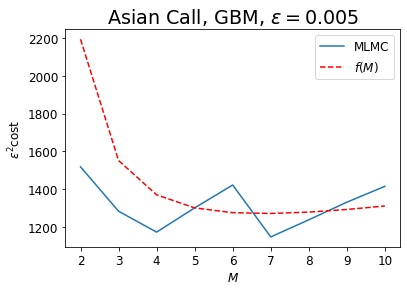

In [18]:
cost_mlmc=[]
cost_mc=[]
for m in [2,3,4,5,6,7,8,9,10]:
    Asian=Asian_GBM()
    e=0.005
    sums,N=Asian.mlmc(e,M=m)
    L=len(N)-1
    means_p=sums[2,:]/N
    V_p=(sums[3,:]/N)-means_p**2

    cost_mlmc+=[(N[0]+(1+1/m)*np.sum(N[1:]*(m**np.arange(1,L+1))))*e**2]
    cost_mc+=[2*sum(V_p*m**np.arange(L+1))]

M=np.array([2,3,4,5,6,7,8,9,10])
plt.plot(M,cost_mlmc,label='MLMC')
sc=cost_mlmc[3]/((M[3]-1/M[3])/(np.log(M[3]))**2)
plt.plot(M,sc*(M-1/M)/(np.log(M))**2,'r--',label='$f(M)$')
plt.legend()
plt.ylabel('$\epsilon^{2}$cost')
plt.xlabel('$M$');
plt.title(f'Asian Call, GBM, $\epsilon={e}$')
plt.savefig('Comparison_Cost_fofM')

In [131]:
plt.figure(figsize=(15,8))
p=[]
mc=[]
eps=np.array([0.005,0.01,0.02,0.05,0.1])
Euro=Euro_GBM(X0=2,sig=0.5,T=2,K=2)
sums,N=Euro.mlmc(5*10**-5,M=4)
'''
p+=[np.sum(sums[0,:]/N)]
plt.plot(eps,p,label='MLMC')
plt.fill_between(eps, p+eps, p-eps, alpha=.5, label='$\pm\epsilon$')
plt.plot(eps,Euro.BS(Euro.K)*np.ones(len(eps)),label='Black-Scholes')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Euro Call Option Price')
plt.title(f'European Call Option, $T={Euro.T}, S(0)={Euro.X0}, K={Euro.K}, r={Euro.r*100}\%, \sigma={Euro.sig}$');
'''

KeyboardInterrupt: 

<Figure size 1080x576 with 0 Axes>

C:\Users\s1505582\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


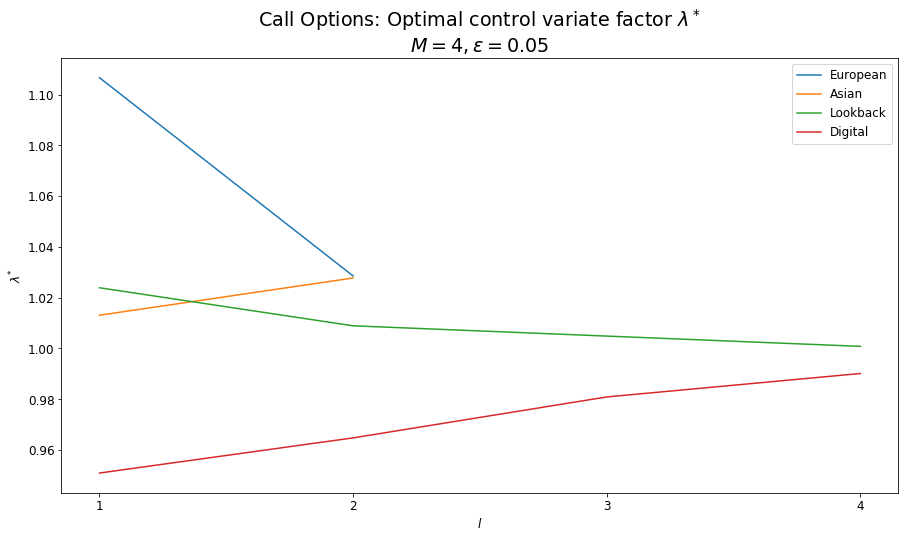

In [26]:
plt.figure(figsize=(15,8))
for label,func in {'European':Euro_GBM,'Asian':Asian_GBM,'Lookback':Lookback_GBM,'Digital':Digital_GBM}.items():
    p=[]
    option=func()
    e=0.05
    M=4
    sums,N=option.mlmc(e,M=M)
    Vg=sums[5,:]/N-(sums[4,:]/N)**2
    lam=((sums[6,:]/N)-(sums[2,:]/N)*(sums[4,:]/N))/Vg
    plt.plot(range(len(N)),lam,label=label)

plt.xlabel('$l$')
plt.ylabel('$\lambda^{*}$')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title(f'Call Options: Optimal control variate factor $\lambda^*$\n$M={M}, \epsilon={e}$');
plt.legend()
plt.savefig('lambdaCallOptions')

1.4548005557289727
0.8239042870226915
1.442814969711483
1.5230229179838555
1.1452609828439757


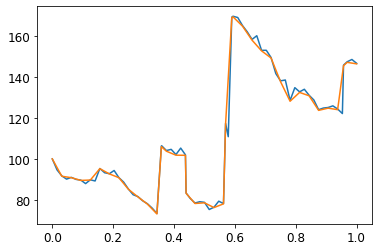

In [57]:
##Jump Diffusion Model Plot
'''
Idea:
___o_X_o__oX_o___X_o___X  | Coarse with jumps
__Xo_X_oX_oX_oX__X_oX__X  | Fine with jumps
-------------oX--X------  | Fine has to have fine timestep
-------------o---X------  | Coarse can have longer increment here, but has to respect jumps

Modelling SDE:
S_t+h=Y*S_t => dS=S_t+h-S_t=(Y-1)*S_t
Q=ln(Y)~N(a,b) for example

~~ dS=(r-c*lam*Jbar)Sdt+sig*S*dW+c*S*dJ ~~

dJ=exp(Q)-1 #Size of jump
Jbar=E[exp(Q)-1] #Expected jump size

'''
X0=100
lam=3
M=2
J_bar=np.exp(0.1+0.5*0.2**2)-1
l=6
T=1
r=0.05
sig=0.2
def ran():
    return 0.1+0.2*np.random.standard_normal()
Nsteps=M**l
N_loop=1
dWc=0
tau=0
t_=0
dtc=0
Xf=[X0]
Xc=[X0]
tf=[0]
tc=[0]


tau+=np.random.exponential(scale=1/lam)
for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
        tn=j*T/Nsteps #Fine timestepping right boundary
        while tau<tn: #If jump is before right boundary...
            dt=tau-t_ #Adaptive step size is from last jump or left fine timestep
            dtc+=dt #Coarse timestep increments
            dWf=np.random.randn()*np.sqrt(dt) #Brownian motion for adaptive time step
            dWc+=dWf #Increment coarse BI
            dJ=np.exp(ran()) #Generate jump
            print(dJ)
            #Develop fine path
            Xf+=[Xf[-1]+(r-lam*J_bar)*Xf[-1]*dt + sig*Xf[-1]*dWf] 
            Xf[-1]*=dJ
            
            #Develop coarse path
            Xc+=[Xc[-1]+(r-lam*J_bar)*Xc[-1]*dtc + sig*Xc[-1]*dWc]
            Xc[-1]*=dJ 
            
            dWc=0 #Reset coarse BI
            dtc=0 #Reset coarse timestep
            t_=tau #Both fine and coarse paths now at t_=latest jump time
            tf+=[t_]
            tc+=[t_]
            tau+=np.random.exponential(scale=1/lam) #Next jump time
        #Next jump time is after current right fine timestep
        dt=tn-t_ #Adaptive time step is time from recent jump or left fine time up to right fine time
        dtc+=dt #Increment coarse timestep
        dWf=np.random.randn()*np.sqrt(dt) #Fine BI for adaptive timestep
        dWc+=dWf #Increment coarse BI
        Xf+=[Xf[-1]+(r-lam*J_bar)*Xf[-1]*dt + sig*Xf[-1]*dWf] #Develope fine timestep
        t_=tn #Fine path now at j*T/Nsteps, set as left boundary
        tf+=[t_]
        if j%M==0: #If reached coarse timepoint, then bring coarse path up to this point
            Xc+=[Xc[-1]+(r-lam*J_bar)*Xc[-1]*dtc + sig*Xc[-1]*dWc]#...Develop coarse path
            tc+=[t_]
            dtc=0
            dWc=0 #...Re-initialise coarse BI to 0
plt.plot(tf,Xf)
plt.plot(tc,Xc)

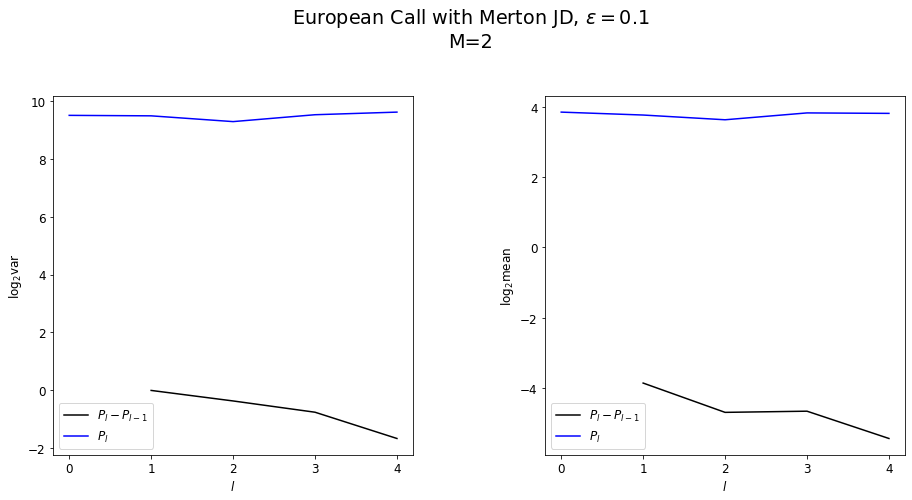

In [67]:
mlmc_complexity(a,,label,M=2):

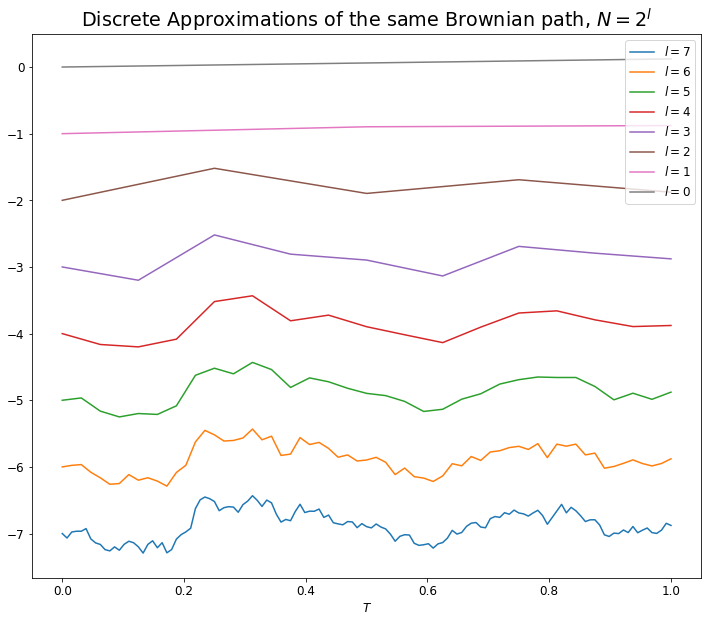

In [58]:
L=8
Nsteps=2**L
dt=1/Nsteps
dWf=np.random.randn(Nsteps)*np.sqrt(dt) #Brownian motion for adaptive time step
plt.figure(figsize=(12,10))
for l in range(L-1,-1,-1):
    dt=2*dt
    dWf=dWf[0::2]+dWf[1::2]
    Wf=[0]
    for dw in dWf:
        Wf.append(Wf[-1]+dw)
    tf=np.arange(0,1+dt,dt)
    plt.plot(tf,np.array(Wf)-l,label=f'$l={l}$')
plt.legend(loc='upper right')
plt.xlabel('$T$')
plt.title('Discrete Approximations of the same Brownian path, $N=2^{l}$')
plt.savefig('Discrete.png')

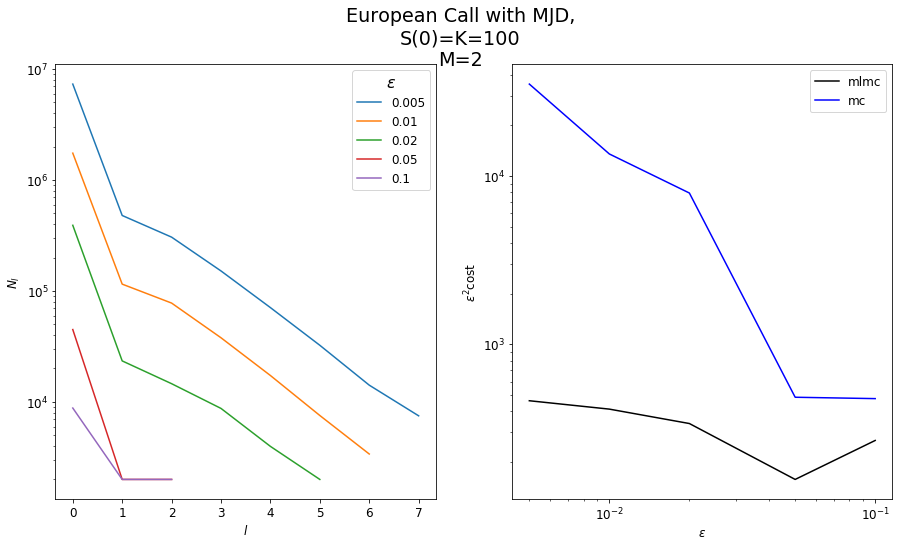

In [65]:
mlmc_complexity(European,[0.005,0.01,0.02,0.05,0.1])

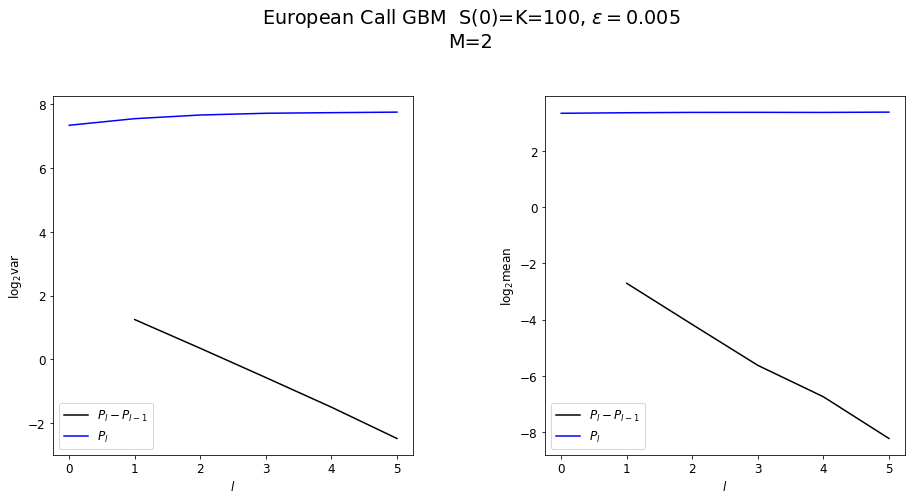

In [12]:
Euro=Euro_GBM()
mlmc_variance(Euro,0.005,label='European Call GBM ')

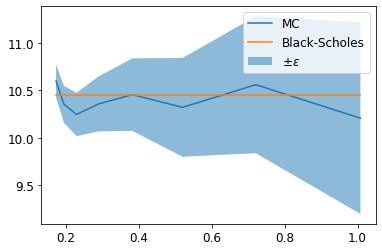

In [91]:
Euro=Euro_GBM()
mc=[]
eps=[]
for l in [0,1,2,3,4,5,6,7]:
    Xf,Xc=Euro.path(10000,l,M=2)
    Pf=np.exp(-0.05)*np.maximum(Xf-100,0)
    mc+=[np.mean(Pf)]
    eps+=[np.sqrt(np.var(Pf)/10000+2**(-l))]
plt.plot(eps,mc,label='MC')
plt.fill_between(eps, np.array(mc)+np.array(eps), np.array(mc)-np.array(eps), alpha=.5, label='$\pm\epsilon$')
plt.plot(eps,Euro.BS(Euro.K)*np.ones(len(eps)),label='Black-Scholes')
plt.legend()